In [1]:
# @title Import Libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import joblib
from collections import defaultdict

from sklearn.model_selection import KFold, cross_validate, TimeSeriesSplit
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost

import matplotlib.dates as mdates
from datetime import timedelta
from dateutil.relativedelta import relativedelta

In [2]:
# @title Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# drive_data_path = "/content/drive/Shareddrives/Ishango/Programs/AIMS_MSc_Theses_Supervision/AIWP/Project26_MLStacking/data/oliver/"
# df = pd.read_pickle(drive_data_path + "era5_ml_setup_500geopotential_32x64_2020.pkl")
# data_path = "/content/drive/MyDrive/_shared_drive_shortcut/MastersProject/Data/"

# data_path = "/content/drive/MyDrive/_shared/MastersProject/Data/"
# data_plot_path = "/content/drive/MyDrive/_shared/MastersProject/Plots/"

data_path="/content/drive/MyDrive/MastersProject/Data/"
data_plot_path="/content/drive/MyDrive/MastersProject/Plots/"


In [6]:
# @title Load forecasts & ERA5 truth

df =pd.read_pickle(data_path+"era5_ml_setup_500geopotential_32x64_2020.pkl")

lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]


for lead_time in lead_times:
    print(lead_time)
    df_aiwp = pd.read_pickle(data_path + f"aiwp_ml_setup_500geopotential_32x64_2020_leadtime{lead_time}.pkl").drop(columns=["area_weight","keisler"])
    df_aiwp = df_aiwp.rename(columns={col: col + "_lt" + str(lead_time) for col in df_aiwp.columns if col not in ["time", "longitude", "latitude"]})
    if lead_time == 48:
      df_aiwp_full = df_aiwp
    else:
      df_aiwp_full = df_aiwp_full.merge(df_aiwp, on=["time", "longitude", "latitude"], how="outer")

print(f"Shape of df :{df.shape}")
print(f"Shape of df_aiwp_full :{df_aiwp_full.shape}")



48
72
96
120
144
168
192
216
240
Shape of df :(1556480, 5)
Shape of df_aiwp_full :(1531904, 39)


In [7]:
# @title Merge ERA5 and Forecasts Across all lead times
full_df = df.merge(df_aiwp_full, on=["time", "longitude", "latitude"], how="outer")
print(full_df.shape)
full_df.head()


(1556480, 41)


,time,longitude,latitude,era5,area_weight,graphcast_lt48,pangu_lt48,neuralgcm_lt48,ifshres_lt48,graphcast_lt72,...,neuralgcm_lt192,ifshres_lt192,graphcast_lt216,pangu_lt216,neuralgcm_lt216,ifshres_lt216,graphcast_lt240,pangu_lt240,neuralgcm_lt240,ifshres_lt240
0,2020-01-01,0.0,-87.1875,49846.941406,0.049068,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-01,0.0,-81.5625,50196.523438,0.146730,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-01,0.0,-75.9375,50391.101562,0.242980,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-01,0.0,-70.3125,49667.398438,0.336890,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-01,0.0,-64.6875,49277.945312,0.427555,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
full_df.isna().sum()

,0
time,0
longitude,0
latitude,0
era5,0
area_weight,0
graphcast_lt48,57344
pangu_lt48,57344
neuralgcm_lt48,57344
ifshres_lt48,57344
graphcast_lt72,57344


In [9]:
# @title Filter for subset of data for each lead time

def data_per_lead_time(df,lead_time):
  valid_time_lower = df['time'][0]+timedelta(days=int(lead_time/24))
  valid_time_upper = valid_time_lower + relativedelta(years=1)
  df_filtered = df[(df['time'] > valid_time_lower) & (df['time'] < valid_time_upper)]
  return df_filtered[['time','latitude','longitude',"era5","area_weight",
                      f'graphcast_lt{lead_time}',
                      f'pangu_lt{lead_time}',
                      f'neuralgcm_lt{lead_time}',
                      # f'keisler_lt{lead_time}'
                      f'ifshres_lt{lead_time}'
                      ]]


In [10]:
for lead_time in lead_times:
  print(lead_time)
  print(data_per_lead_time(full_df,lead_time).isna().sum())

48
time              0
latitude          0
longitude         0
era5              0
area_weight       0
graphcast_lt48    0
pangu_lt48        0
neuralgcm_lt48    0
ifshres_lt48      0
dtype: int64
72
time              0
latitude          0
longitude         0
era5              0
area_weight       0
graphcast_lt72    0
pangu_lt72        0
neuralgcm_lt72    0
ifshres_lt72      0
dtype: int64
96
time              0
latitude          0
longitude         0
era5              0
area_weight       0
graphcast_lt96    0
pangu_lt96        0
neuralgcm_lt96    0
ifshres_lt96      0
dtype: int64
120
time               0
latitude           0
longitude          0
era5               0
area_weight        0
graphcast_lt120    0
pangu_lt120        0
neuralgcm_lt120    0
ifshres_lt120      0
dtype: int64
144
time               0
latitude           0
longitude          0
era5               0
area_weight        0
graphcast_lt144    0
pangu_lt144        0
neuralgcm_lt144    0
ifshres_lt144      0
dtype: int64


In [11]:
# @title Plot the train-test splits for each Fold

def cross_validation_plot(df, cv, lead_time):
  # Extract datetime info using the filtered df
  time_index = df["time"].reset_index(drop=True)

  # Store train/test index lists
  train_indices_list = []
  test_indices_list = []
  for train_index, test_index in cv.split(X):
      train_indices_list.append(train_index)
      test_indices_list.append(test_index)

  # Create the plot
  fig, ax = plt.subplots(figsize=(12, 6))

  # Plot each fold
  for i in range(10):
      # Convert indices to datetime for x-axis
      train_times = time_index.iloc[train_indices_list[i]]
      test_times = time_index.iloc[test_indices_list[i]]

      ax.plot(train_times, [i + 1] * len(train_times), 'bo', label='Train' if i == 0 else "", markersize=5)
      ax.plot(test_times, [i + 1] * len(test_times), 'ro', label='Test' if i == 0 else "", markersize=5)
      ax.axhline(y=i + 1.5, color='lightgray', linestyle='--')

  # Format x-axis as months
  ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
  ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))

  # Labels and title
  ax.set_xlabel('Month')
  ax.set_ylabel('Fold')
  ax.set_yticks(range(1, 11))
  ax.set_yticklabels([f'Fold {i+1}' for i in range(10)])
  ax.set_title(f'Training, Gap and Testing Windows Across 10 Folds for {lead_time} hours lead time.')
  ax.legend(loc='upper right')

  # Improve layout and save
  plt.tight_layout()
  # plt.savefig(data_plot_path + f'Training_Testing_Folds_By_Month_{lead_time}.pdf',
  #             dpi=300, bbox_inches="tight")

  plt.show()


In [22]:
# @title Shapely Values for Feature importance

import shap
def shapely_values_plot(model,X_train):
  explainer = shap.TreeExplainer(model=model)
  shap_values = explainer(X_train)
  shap.plots.beeswarm(shap_values)
  shap.plots.bar(shap_values, max_display=12)

In [25]:
# @title RMSE Comparison for each model and fold

def train_and_evaluate(xgb, cv,X,y, area_weight,lead_time):
  # Create a dictionary to store the results for each fold
  results = {}
  X_train_folds =[]

  for fold, (train_index, test_index) in enumerate(cv.split(X)):
      print(f"Fold {fold+1}:")
      fold_results = {}

      X_train, X_test = X.iloc[train_index], X.iloc[test_index]
      y_train, y_test = y.iloc[train_index], y.iloc[test_index]

      X_train_folds.append(X_train)

      xgb.fit(X_train, y_train, sample_weight=area_weight.iloc[train_index])



      y_pred = xgb.predict(X_test)
      mse = mean_squared_error(y_test, y_pred)
      print(f"  mse: {mse}")

      area_weighted_rmse = np.sqrt(((y_test-y_pred)**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
      print(f"  PiggyCast: area weighted rmse: {area_weighted_rmse}")
      fold_results["PiggyCast"] = area_weighted_rmse

      for model in [f"graphcast_lt{lead_time}",
                    f"pangu_lt{lead_time}",
                    f"neuralgcm_lt{lead_time}",
                    # f"keisler_lt{lead_time}",
                    f"ifshres_lt{lead_time}"]:
          area_weighted_rmse = np.sqrt(((y_test-X_test[model])**2 * area_weight.iloc[test_index]).mean() / area_weight.iloc[test_index].mean())
          print(f"  {model.split('_')[0]}: area weighted rmse: {area_weighted_rmse}")
          fold_results[model.split('_')[0]] = area_weighted_rmse

      results[fold+1] = fold_results

  # shapely plots

  shapely_values_plot(xgb, X_train_folds)

  return results



In [13]:
# @title Plot RMSE per fold and Model
def rmse_per_fold_plot(results, lead_time):
  fig, ax = plt.subplots(figsize=(8, 6))

  for model in results[1].keys():  # Iterate through all model names
      rmse_values = [results[fold][model] for fold in results]
      fold_numbers = list(results.keys())
      ax.plot(fold_numbers, rmse_values, label=model, marker='o')

  ax.set_xlabel('Fold')
  ax.set_ylabel('RMSE')
  ax.set_title(f'RMSE for Each Fold and Model at {lead_time} hours lead time.')
  ax.legend(loc="upper right")
  plt.grid(True)
  # plt.savefig(data_plot_path + f'RMSE_for_Each_Fold_and_Model_{lead_time}.pdf', dpi=300, bbox_inches="tight")

  plt.show()


Lead time: 48
Shape of x :(1497088, 6)
Shape of y : (1497088,)


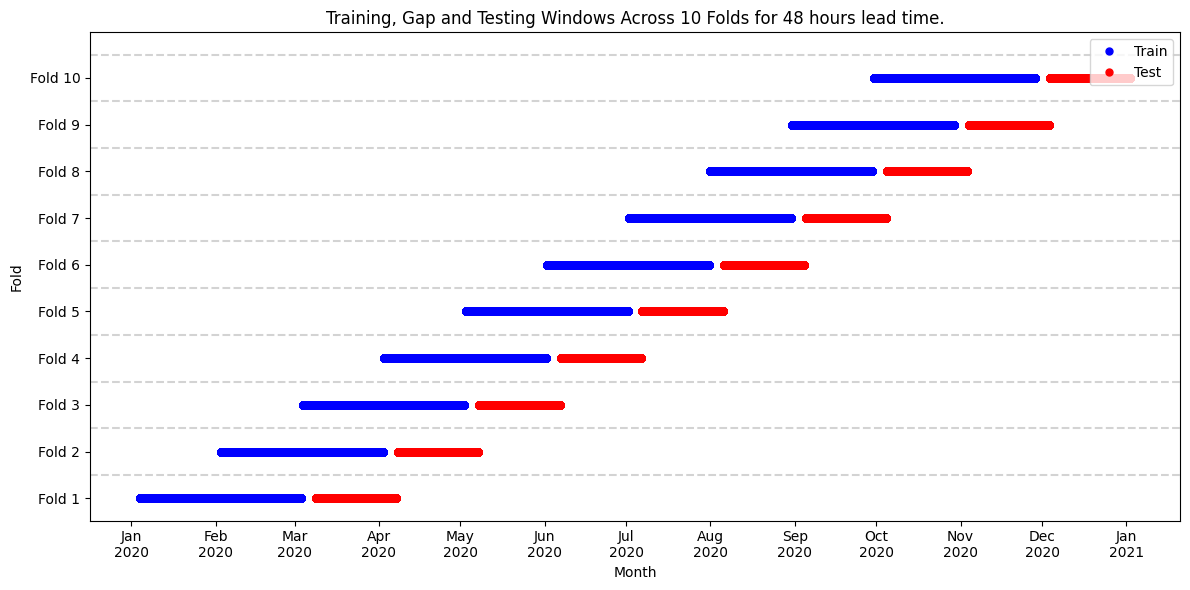

Fold 1:
  mse: 15209.0927734375
  PiggyCast: area weighted rmse: 76.76277746972184
  graphcast: area weighted rmse: 72.89521727913798
  pangu: area weighted rmse: 81.53557879205798
  neuralgcm: area weighted rmse: 61.32865112702906
  ifshres: area weighted rmse: 77.69317822238818
Fold 2:
  mse: 9210.8720703125
  PiggyCast: area weighted rmse: 66.86750469041097
  graphcast: area weighted rmse: 70.89595346008002
  pangu: area weighted rmse: 80.0969255422813
  neuralgcm: area weighted rmse: 62.04284877201307
  ifshres: area weighted rmse: 76.40121126092066
Fold 3:
  mse: 7203.16845703125
  PiggyCast: area weighted rmse: 64.48324208575639
  graphcast: area weighted rmse: 70.5749420055696
  pangu: area weighted rmse: 74.76480428843476
  neuralgcm: area weighted rmse: 61.50660557160111
  ifshres: area weighted rmse: 74.98039911101573
Fold 4:
  mse: 10929.08203125
  PiggyCast: area weighted rmse: 74.77433859172058
  graphcast: area weighted rmse: 67.91825353957019
  pangu: area weighted rmse:

ValueError: Please reshape the input data into 2-dimensional matrix.

In [26]:
# @title Training and Evaluation Loop

# Initialize xgb regressor
xgb = xgboost.XGBRegressor(random_state=42, device="cuda")

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)

# Lead Times
# , 72, 96, 120, 144, 168, 192, 216, 240
lead_times=[48]

nested_scores = {} # Nested scores for each lead time
rmse_results = {} # rmse results for each lead time, models

for lead_time in lead_times:
  print(f"Lead time: {lead_time}")

  df_filtered = data_per_lead_time(full_df,lead_time)

  X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
                   f"neuralgcm_lt{lead_time}",
                  #  f"keisler_lt{lead_time}",
                   f"ifshres_lt{lead_time}", "longitude", "latitude"]]
  y = df_filtered["era5"]
  area_weight = df_filtered["area_weight"]

  print(f"Shape of x :{X.shape}")
  print(f"Shape of y : {y.shape}")

  # Nested Scores
  nested_score = cross_validate(xgb, X=X, y=y, cv=cv_timeseries,
                              scoring=('neg_mean_squared_error', 'r2'),
                              params={'sample_weight': area_weight}
                              )
  nested_scores[lead_time] = nested_score

  # Cross validation plot
  cross_validation_plot(df_filtered, cv_timeseries, lead_time)

  # RMSE
  rmse_result = train_and_evaluate(xgb, cv_timeseries,X,y, area_weight, lead_time)
  rmse_results[lead_time] = rmse_result

  # RMSE plots per model
  rmse_per_fold_plot(rmse_result, lead_time)



In [ ]:
# @title Save RMSE Results and Model
joblib.dump(rmse_results, data_path + "rmse_results.pkl")
joblib.dump(xgb, data_path+ 'xgb_model.pkl')

['/content/drive/MyDrive/MastersProject/Data/xgb_model.pkl']

In [ ]:
# @title Load RMSE Results and Model
rmse_results = joblib.load(data_path + "rmse_results.pkl")
xgb = joblib.load(data_path+ 'xgb_model.pkl')

In [15]:
# @title Calculate RMSE Mean of Model per Lead time

def rmse_mean_per_lead_time_and_model(rmse_results):
  # average scores per lead time and model
  average_scores = {}

  for lead_time, folds in rmse_results.items():
      model_scores = defaultdict(list)

      # collect values per model
      for fold_scores in folds.values():
          for model, value in fold_scores.items():
              model_scores[model].append(value)

      # average for each model
      average_scores[lead_time] = {model: float(np.mean(scores)) for model, scores in model_scores.items()}
  return average_scores



In [16]:
# print nicely
from pprint import pprint
average_scores = rmse_mean_per_lead_time_and_model(rmse_results)
pprint(average_scores)

{48: {'PiggyCast': 64.1775584914425,
      'graphcast': 69.63800331707469,
      'ifshres': 74.18631782545808,
      'neuralgcm': 60.76147382469113,
      'pangu': 75.75723848328518},
 72: {'PiggyCast': 101.99432560939412,
      'graphcast': 115.48760779732575,
      'ifshres': 124.99237446580557,
      'neuralgcm': 105.10781897069894,
      'pangu': 125.83565063238966},
 96: {'PiggyCast': 159.17793967232666,
      'graphcast': 179.66465739456424,
      'ifshres': 197.23465344920965,
      'neuralgcm': 169.5452751589802,
      'pangu': 196.21785805711082},
 120: {'PiggyCast': 235.87207436116574,
       'graphcast': 263.02001145458746,
       'ifshres': 288.772845868478,
       'neuralgcm': 252.5258417125255,
       'pangu': 285.7960725176161},
 144: {'PiggyCast': 324.301274983238,
       'graphcast': 359.0340948409652,
       'ifshres': 392.49669635762825,
       'neuralgcm': 347.88904311399256,
       'pangu': 387.42279441340935},
 168: {'PiggyCast': 418.30397698636364,
       'graphc

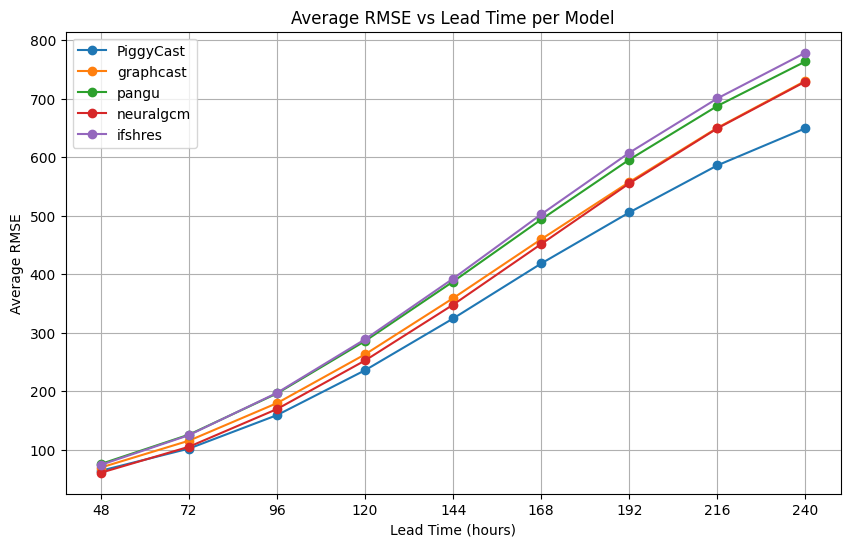

In [17]:
# @title Plot RMSE per lead time and Model
def rmse_per_lead_time_plot_all_lead_times(average_scores):
  models = list(average_scores[next(iter(average_scores))].keys())

  fig, ax = plt.subplots(figsize=(10, 6))

  for model in models:
      avg_rmse_per_lead_time = []
      lead_times = []

      for lead_time, lead_time_average in average_scores.items():
          avg_rmse_per_lead_time.append(lead_time_average[model])
          lead_times.append(lead_time)

      ax.plot(lead_times, avg_rmse_per_lead_time, label=model, marker='o')

  ax.set_xlabel("Lead Time (hours)")
  ax.set_ylabel("Average RMSE")
  ax.set_title("Average RMSE vs Lead Time per Model")
  ax.set_xticks(range(min(lead_times), max(lead_times)+1, 24))  # Set interval of 24 hours
  ax.legend(loc="upper left")
  plt.grid(True)
  # plt.savefig(data_plot_path + 'Average_RMSE_vs_Lead_Time_per_Model.pdf', dpi=300, bbox_inches="tight")
  plt.show()

rmse_per_lead_time_plot_all_lead_times(average_scores)


In [19]:
# @title Plot % Improvement over IFS HRES per fold and model
def plot_improvement_over_ifshres(results, lead_time):
    fig, ax = plt.subplots(figsize=(8, 6))

    for model in results[1].keys():
        if model == 'ifshres':
            continue  # Skip baseline itself

        improvement_values = []
        for fold in results:
            rmse_ifshres = results[fold]['ifshres']
            rmse_model = results[fold][model]
            improvement = ((rmse_ifshres - rmse_model) / rmse_ifshres) * 100
            improvement_values.append(improvement)

        ax.plot(list(results.keys()), improvement_values, label=model, marker='o')

    ax.set_xlabel('Fold')
    ax.set_ylabel('% Improvement over IFS HRES')
    ax.set_title(f'RMSE % Improvement over IFS HRES at {lead_time} hours lead time.')
    ax.legend(loc="lower center")
    plt.grid(True)
    plt.show()




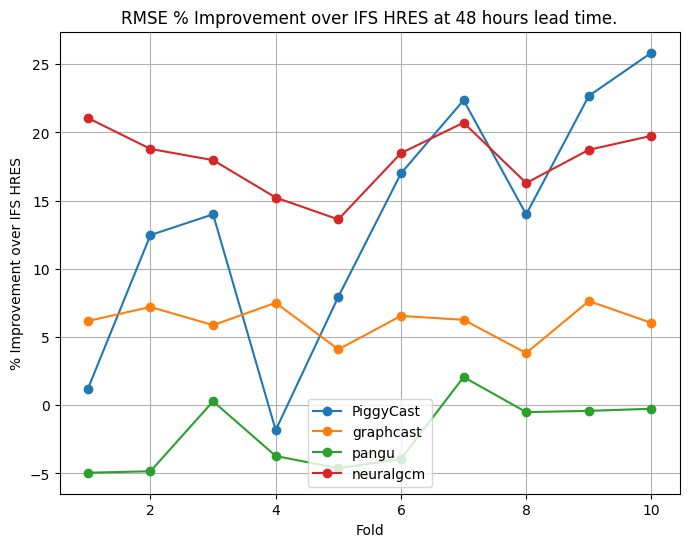

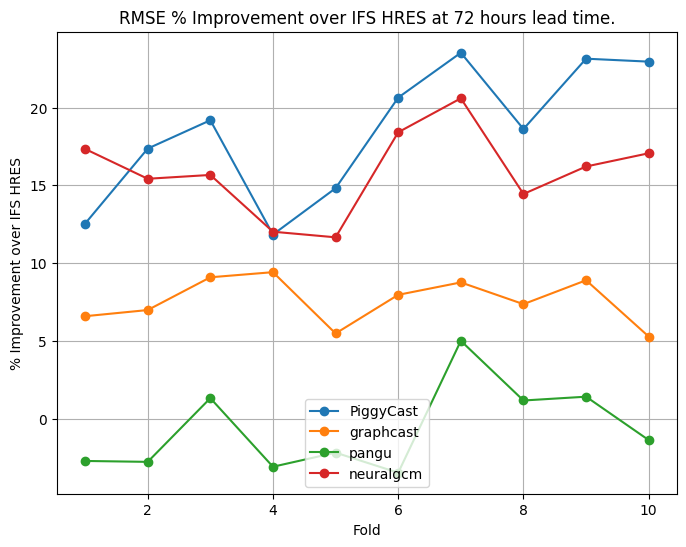

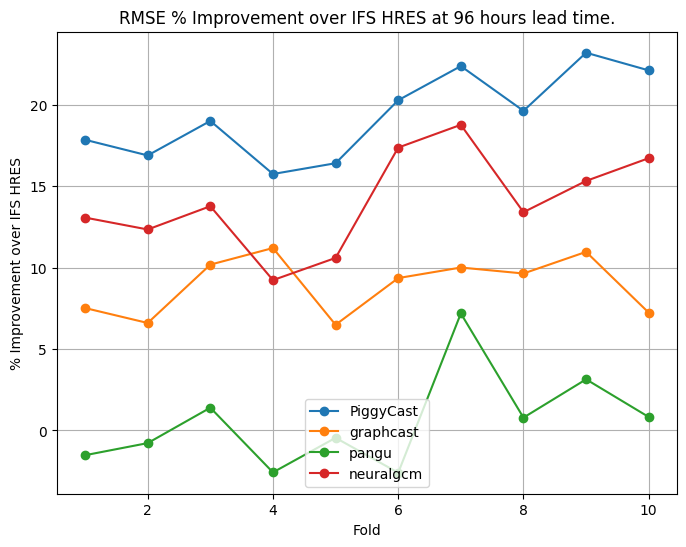

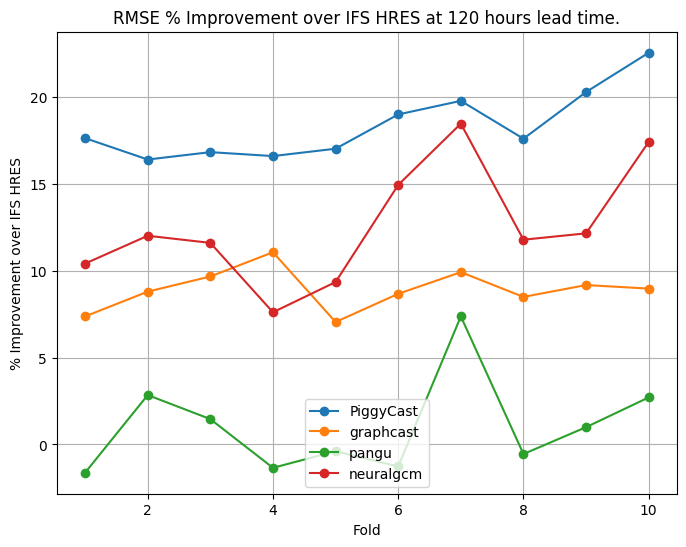

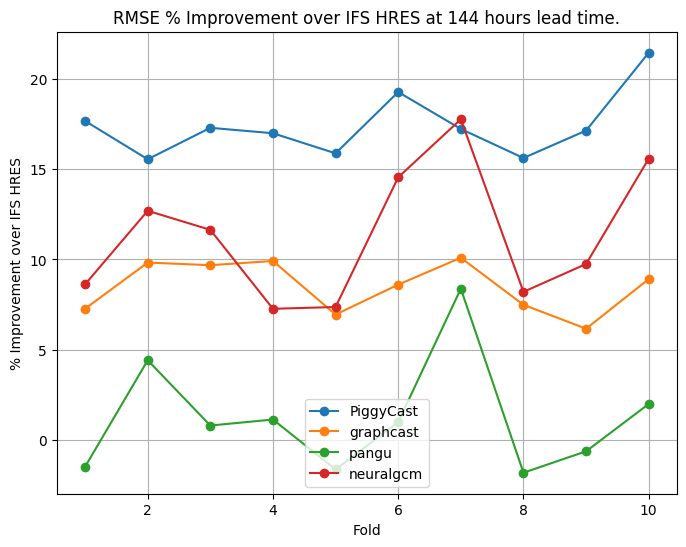

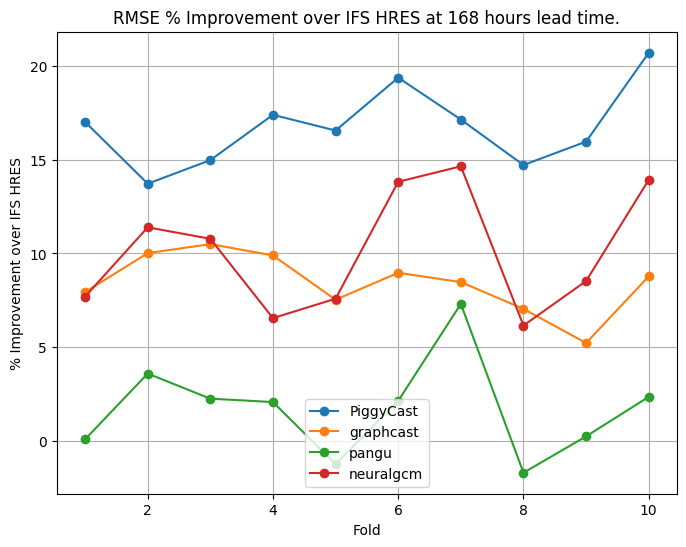

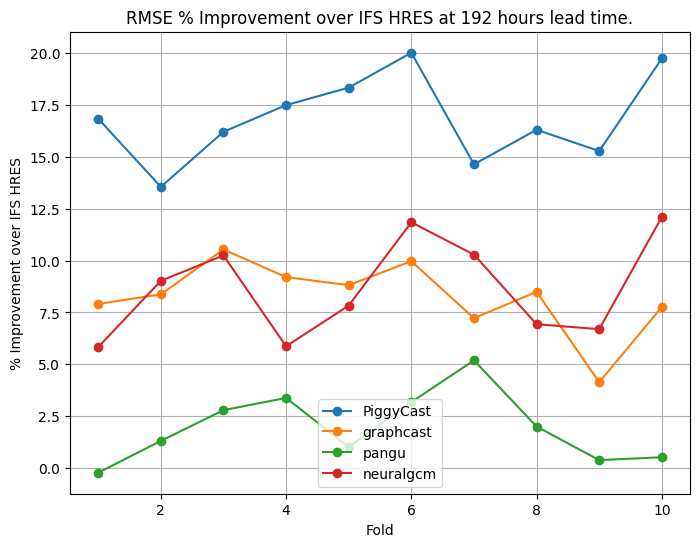

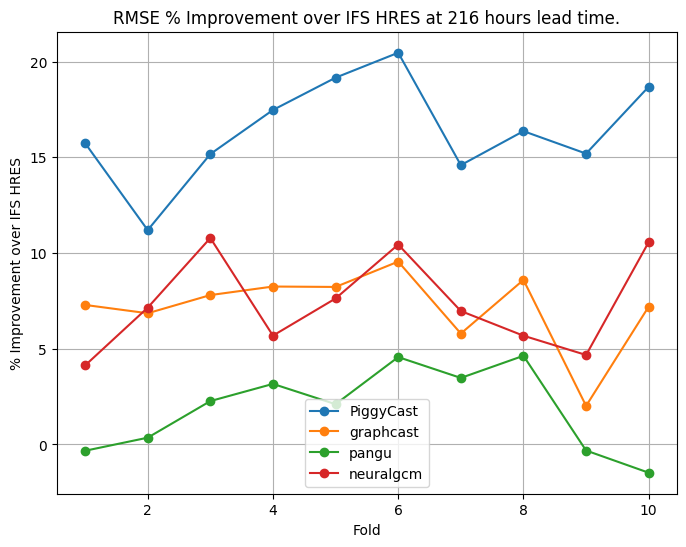

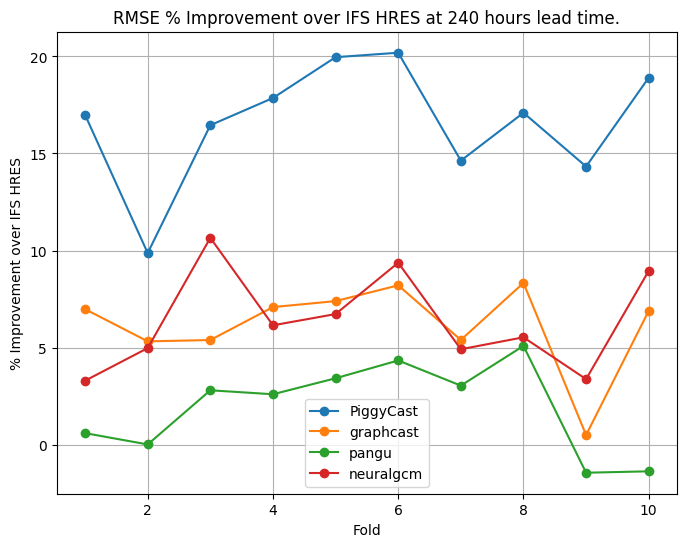

In [20]:
for lead_time in lead_times:
  plot_improvement_over_ifshres(rmse_results[lead_time], lead_time)

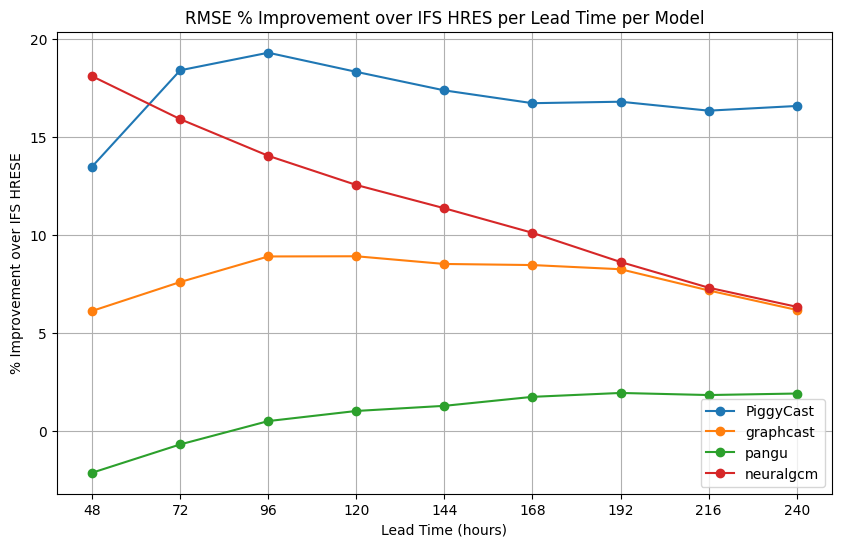

In [ ]:
# @title Plot % Improvement over IFS HRES per lead time and model
def percent_improvement_over_ifshres_per_lead_time(average_scores):
  models = list(average_scores[next(iter(average_scores))].keys())

  fig, ax = plt.subplots(figsize=(10, 6))

  for model in models:
      if model == 'ifshres':
          continue  # Skip baseline itself

      percentage_improvement = []
      lead_times = []

      for lead_time, lead_time_average in average_scores.items():
          rmse_ifshres = lead_time_average['ifshres']
          rmse_model = lead_time_average[model]
          improvement = ((rmse_ifshres - rmse_model) / rmse_ifshres) * 100
          percentage_improvement.append(improvement)
          lead_times.append(lead_time)

      ax.plot(lead_times, percentage_improvement, label=model, marker='o')

  ax.set_xlabel("Lead Time (hours)")
  ax.set_ylabel("% Improvement over IFS HRESE")
  ax.set_title("RMSE % Improvement over IFS HRES per Lead Time per Model")
  ax.set_xticks(range(min(lead_times), max(lead_times)+1, 24))
  ax.legend(loc="lower right")
  plt.grid(True)
  # plt.savefig(data_plot_path + 'Average_RMSE_vs_Lead_Time_per_Model.pdf', dpi=300, bbox_inches="tight")
  plt.show()

percent_improvement_over_ifshres_per_lead_time(average_scores)


In [ ]:
base_columns = ["graphcast", "pangu", "neuralgcm", "keisler", "ifshres", "longitude", "latitude"]

def standardize_columns(df, lead_time):
    cols = [f"{model}_lt{lead_time}" for model in ["graphcast", "pangu", "neuralgcm", "keisler", "ifshres"]]
    cols += ["longitude", "latitude"]
    df = df[cols]
    df.columns = base_columns  # Rename to standard
    return df


In [ ]:

import gc

# Calculate Cross-Validation using 10 folds
cv_timeseries = TimeSeriesSplit(n_splits=10, max_train_size=32 * 64 * 2 * 60,
                                test_size= 32 * 64 * 2 * 30, gap=32 * 64 * 2 * 5)

X_train_full=[]
lead_times=[48, 72, 96, 120, 144, 168, 192, 216, 240]
# lead_time_=[48,72,96,120]
for lead_time in lead_times:
  print(f"Lead time: {lead_time}")

  df_filtered = data_per_lead_time(full_df,lead_time)
  X = standardize_columns(df_filtered, lead_time)
  # X = df_filtered[[f"graphcast_lt{lead_time}", f"pangu_lt{lead_time}",
  #                  f"neuralgcm_lt{lead_time}",f"keisler_lt{lead_time}",
  #                  f"ifshres_lt{lead_time}", "longitude", "latitude"]]

  print(f"Shape of x :{X.shape}")

  for fold, (train_index, test_index) in enumerate(cv_timeseries.split(X)):
      X_train = X.iloc[train_index]
      X_train_full.append(X_train)

      del X_train
      gc.collect()  # Request garbage collection

# X_train_full = pd.concat(X_train_full, axis=0).reset_index(drop=True)
# X_train_full


Lead time: 48
Shape of x :(1497088, 7)
Lead time: 72
Shape of x :(1497088, 7)
Lead time: 96
Shape of x :(1497088, 7)
Lead time: 120
Shape of x :(1497088, 7)
Lead time: 144
Shape of x :(1497088, 7)
Lead time: 168
Shape of x :(1497088, 7)
Lead time: 192
Shape of x :(1497088, 7)
Lead time: 216
Shape of x :(1497088, 7)
Lead time: 240
Shape of x :(1497088, 7)


In [ ]:
len(X_train_full)

22118400

In [ ]:
import pandas as pd
import gc

def safe_concat(df_list, batch_size=5):
    """Concatenate a large list of DataFrames in smaller batches to reduce memory spikes."""
    while len(df_list) > 1:
        new_df_list = []
        for i in range(0, len(df_list), batch_size):
            batch = df_list[i:i+batch_size]
            new_df = pd.concat(batch, axis=0)
            new_df_list.append(new_df)
            del batch
            gc.collect()
        df_list = new_df_list
    return df_list[0]


X_train_full = safe_concat(X_train_full)


In [ ]:
X_train_full.shape

(22118400, 7)

In [ ]:
X_train_full.head()

,graphcast_lt,pangu_lt,neuralgcm_lt,keisler_lt,ifshres_lt,longitude,latitude
12288,50068.417969,50013.507812,50068.015625,50182.296875,50147.375000,0.0,-87.1875
12289,50274.988281,50264.234375,50247.695312,50403.031250,50339.343750,0.0,-81.5625
12290,50362.257812,50386.644531,50354.066406,50523.511719,50406.281250,0.0,-75.9375
12291,50014.953125,50028.437500,49964.816406,50108.476562,50037.742188,0.0,-70.3125
12292,49217.886719,49196.429688,49140.609375,49191.601562,49255.343750,0.0,-64.6875


In [ ]:
import shap
explainer = shap.TreeExplainer(model=xgb)
shap_values = explainer(X_train_full)
shap.plots.beeswarm(shap_values)
shap.plots.bar(shap_values, max_display=12)